In [1]:
%matplotlib inline
import os,random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as cPickle, random, sys, keras
import scipy
from sklearn import preprocessing
import tensorflow as tf
from numpy.fft import *


from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf

Xd = cPickle.load(open("RML2016.10b.dat",'rb'), encoding='latin1')

In [2]:
INTENSITY_AXIS=0
QUADRATURE_AXIS=1

snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])

X_Intensity = []  
X_Quadrature = []
Label_strings = []
for mod in mods:
    X_Intensity.append(Xd[(mod,18)][:,INTENSITY_AXIS,:])
    X_Quadrature.append(Xd[(mod,18)][:,QUADRATURE_AXIS,:])
    for label in range(len(Xd[(mod,18)][:,INTENSITY_AXIS,:])):
        Label_strings.append(mod)
X_Intensity = np.vstack(X_Intensity) # Quick way to create stacked dataset
X_Quadrature = np.vstack(X_Quadrature)

Label_strings=np.vstack(Label_strings)
complex_num = X_Intensity + 1j*X_Quadrature


In [3]:
X_Intensity_FFT = abs(np.fft.fftshift(fft(X_Intensity[:]-np.mean(X_Intensity[:]))))
X_Quadrature_FFT = abs(np.fft.fftshift(fft(X_Quadrature[:]-np.mean(X_Quadrature[:]))))
X_complex_FFT = abs(np.fft.fftshift(fft(complex_num[:]-np.mean(complex_num[:]))))

X_Power_Intensity_FFT = X_Intensity_FFT**2
X_Power_Quadrature_FFT = X_Quadrature_FFT**2
X_Power_complex_FFT = X_complex_FFT**2

In [4]:
X_Power_Intensity_FFT.shape

(60000, 128)

In [5]:
le= preprocessing.LabelEncoder()
le.fit(Label_strings)
Label_Y_numbers = le.transform(Label_strings)
depth = 10
Label = tf.one_hot(Label_Y_numbers,depth)

/home/jax/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [6]:
X_Intensity_Label = np.c_[X_Power_Intensity_FFT, Label]
X_Quadrature_Label = np.c_[X_Power_Quadrature_FFT,Label]
X_complex_Label = np.c_[X_Power_complex_FFT,Label]

X_Intensity_Label.shape

(60000, 138)

In [7]:
import copy
X_Intensity_Label_shuffled = copy.copy(X_Intensity_Label) # Create another copy to shuffle
X_Quadratue_Label_shuffled = copy.copy(X_Quadrature_Label)
X_complex_Label_shuffled = copy.copy(X_complex_Label)

np.random.shuffle(X_Intensity_Label_shuffled)
np.random.shuffle(X_Quadratue_Label_shuffled)
np.random.shuffle(X_complex_Label_shuffled)

length_of_X_train = int(0.7*X_Intensity_Label_shuffled.shape[0]) #42000
length_of_X_validation = (int(0.2*X_Intensity_Label_shuffled.shape[0]))+length_of_X_train #12000
length_of_X_train

42000

In [8]:
Train_Intensity = X_Intensity_Label_shuffled[0:length_of_X_train,0:128]
Y_Intensity = X_Intensity_Label_shuffled[0:length_of_X_train,128:]

Validation_Intensity = X_Intensity_Label_shuffled[length_of_X_train:length_of_X_validation,0:128]
Y_Validation = X_Intensity_Label_shuffled[length_of_X_train:length_of_X_validation,128:]

Y_Intensity.shape

(42000, 10)

In [9]:
#callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=6)
model_Power_Intensity = Sequential()
model_Power_Intensity.add(Dense(128, input_dim=128, activation='relu'))
model_Power_Intensity.add(Dense(64, activation='relu'))
model_Power_Intensity.add(Dense(32, activation='relu'))
model_Power_Intensity.add(Dense(10, activation='softmax'))

model_Power_Intensity.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])

In [10]:
history_Power_Intensity = model_Power_Intensity.fit(Train_Intensity, Y_Intensity, validation_data=(Validation_Intensity, Y_Validation), epochs=250, batch_size=100,
                    callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto')])

Epoch 1/250
420/420 [==============================] - 1s 2ms/step - loss: 1.6434 - accuracy: 0.3397 - val_loss: 1.3688 - val_accuracy: 0.4342
Epoch 2/250
420/420 [==============================] - 1s 2ms/step - loss: 1.3000 - accuracy: 0.4400 - val_loss: 1.2228 - val_accuracy: 0.4782
Epoch 3/250
420/420 [==============================] - 1s 2ms/step - loss: 1.2067 - accuracy: 0.4686 - val_loss: 1.1719 - val_accuracy: 0.4762
Epoch 4/250
420/420 [==============================] - 1s 2ms/step - loss: 1.1703 - accuracy: 0.4821 - val_loss: 1.1500 - val_accuracy: 0.4985
Epoch 5/250
420/420 [==============================] - 1s 1ms/step - loss: 1.1487 - accuracy: 0.4856 - val_loss: 1.1288 - val_accuracy: 0.5032
Epoch 6/250
420/420 [==============================] - 1s 2ms/step - loss: 1.1357 - accuracy: 0.4959 - val_loss: 1.1012 - val_accuracy: 0.5169
Epoch 7/250
420/420 [==============================] - 2s 4ms/step - loss: 1.1239 - accuracy: 0.5001 - val_loss: 1.0979 - val_accuracy: 0.5068

Epoch 58/250
420/420 [==============================] - 1s 1ms/step - loss: 0.9547 - accuracy: 0.5609 - val_loss: 0.9571 - val_accuracy: 0.5581
Epoch 59/250
420/420 [==============================] - 1s 3ms/step - loss: 0.9529 - accuracy: 0.5593 - val_loss: 0.9670 - val_accuracy: 0.5502
Epoch 60/250
420/420 [==============================] - 1s 2ms/step - loss: 0.9529 - accuracy: 0.5577 - val_loss: 0.9444 - val_accuracy: 0.5623
Epoch 61/250
420/420 [==============================] - 1s 2ms/step - loss: 0.9523 - accuracy: 0.5596 - val_loss: 0.9450 - val_accuracy: 0.5646
Epoch 62/250
420/420 [==============================] - 1s 2ms/step - loss: 0.9515 - accuracy: 0.5600 - val_loss: 0.9573 - val_accuracy: 0.5596
Epoch 63/250
420/420 [==============================] - 2s 4ms/step - loss: 0.9507 - accuracy: 0.5569 - val_loss: 0.9471 - val_accuracy: 0.5635
Epoch 64/250
420/420 [==============================] - 2s 4ms/step - loss: 0.9505 - accuracy: 0.5577 - val_loss: 0.9492 - val_accuracy:

In [ ]:
_, accuracy = model_Power_Intensity.evaluate(Validation_Intensity, Y_Validation)
print('Accuracy: %.2f' % (accuracy*100))

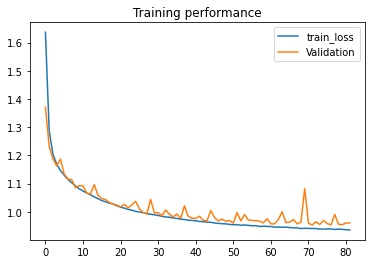

In [53]:
plt.figure()
plt.title('Training performance')
plt.plot(history_Power_Intensity.history['loss'], label='train_loss')
plt.plot(history_Power_Intensity.history['val_loss'], label='Validation')
plt.legend()
plt.show()


In [40]:
Train_Quadrature = X_Quadratue_Label_shuffled[0:length_of_X_train,0:128]
Y_Quadrature = X_Quadratue_Label_shuffled[0:length_of_X_train,128:]

Validation_Quadraturey = X_Quadratue_Label_shuffled[length_of_X_train:length_of_X_validation,0:128]
Y_Validation_Quadrature = X_Quadratue_Label_shuffled[length_of_X_train:length_of_X_validation,128:]

In [41]:
#callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=6)

model_Quadrature = Sequential()
model_Quadrature.add(Dense(128, input_dim=128, activation='relu'))
model_Quadrature.add(Dense(64, activation='relu'))
model_Quadrature.add(Dense(32, activation='relu'))
model_Quadrature.add(Dense(10, activation='softmax'))

model_Quadrature.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])

In [42]:
history_Quadrature = model_Quadrature.fit(Train_Quadrature, Y_Quadrature, epochs=4000,validation_data=(Validation_Quadraturey, Y_Validation_Quadrature), batch_size=100,
                     callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto')])

Epoch 1/4000
420/420 [==============================] - 1s 3ms/step - loss: 1.6170 - accuracy: 0.3470 - val_loss: 1.3410 - val_accuracy: 0.4213
Epoch 2/4000
420/420 [==============================] - 1s 2ms/step - loss: 1.2685 - accuracy: 0.4604 - val_loss: 1.2597 - val_accuracy: 0.4698
Epoch 3/4000
420/420 [==============================] - 1s 1ms/step - loss: 1.2191 - accuracy: 0.4771 - val_loss: 1.2125 - val_accuracy: 0.4795
Epoch 4/4000
420/420 [==============================] - 1s 1ms/step - loss: 1.1954 - accuracy: 0.4803 - val_loss: 1.1899 - val_accuracy: 0.4945
Epoch 5/4000
420/420 [==============================] - 1s 1ms/step - loss: 1.1733 - accuracy: 0.4898 - val_loss: 1.1604 - val_accuracy: 0.5057
Epoch 6/4000
420/420 [==============================] - 1s 1ms/step - loss: 1.1578 - accuracy: 0.4950 - val_loss: 1.1542 - val_accuracy: 0.4922
Epoch 7/4000
420/420 [==============================] - 1s 1ms/step - loss: 1.1422 - accuracy: 0.5001 - val_loss: 1.1536 - val_accuracy:

In [43]:
_, accuracy = model_Quadrature.evaluate(Validation_Quadraturey, Y_Validation_Quadrature)
print('Accuracy: %.2f' % (accuracy*100))


375/375 [==============================] - 0s 1ms/step - loss: 0.9507 - accuracy: 0.5707
Accuracy: 57.07


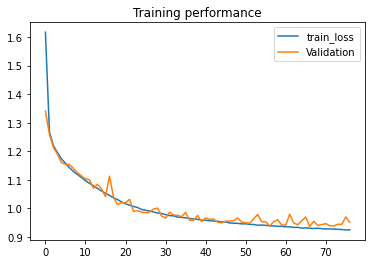

In [44]:
plt.figure()
plt.title('Training performance')
#plt.plot(history3.epoch, history3.history['loss'], label='train loss+error')
#plt.plot(history3.epoch, history3.history['val_loss'], label= 'val_loss')
plt.plot(history_Quadrature.history['loss'], label='train_loss')
plt.plot(history_Quadrature.history['val_loss'], label='Validation')
plt.legend()
plt.show()


In [54]:
Train_complex = X_complex_Label_shuffled[0:length_of_X_train,0:128]
Y_complex = X_complex_Label_shuffled[0:length_of_X_train,128:]

print(Train_complex.shape)
Validation_complex = X_complex_Label_shuffled[length_of_X_train:length_of_X_validation,0:128]
Y_validation_complex = X_complex_Label_shuffled[length_of_X_train:length_of_X_validation,128:]

(42000, 128)


In [55]:
#callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)

model3 = Sequential()
model3.add(Dense(128, input_dim=128, activation='relu'))
model3.add(Dense(64, activation='relu'))
model3.add(Dense(32, activation='relu'))
model3.add(Dense(10, activation='softmax'))

model3.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])

In [56]:
history3 = model3.fit(Train_complex, Y_complex, epochs=6000, batch_size=100,validation_data=(Validation_complex, Y_validation_complex),
    callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto')])

Epoch 1/6000
420/420 [==============================] - 2s 4ms/step - loss: 1.5776 - accuracy: 0.3576 - val_loss: 1.3540 - val_accuracy: 0.4242
Epoch 2/6000
420/420 [==============================] - 1s 1ms/step - loss: 1.2389 - accuracy: 0.4826 - val_loss: 1.1056 - val_accuracy: 0.5807
Epoch 3/6000
420/420 [==============================] - 1s 2ms/step - loss: 1.0323 - accuracy: 0.5706 - val_loss: 0.9985 - val_accuracy: 0.5716
Epoch 4/6000
420/420 [==============================] - 1s 1ms/step - loss: 0.9392 - accuracy: 0.5952 - val_loss: 0.8964 - val_accuracy: 0.6097
Epoch 5/6000
420/420 [==============================] - 1s 1ms/step - loss: 0.8668 - accuracy: 0.6166 - val_loss: 0.8391 - val_accuracy: 0.6142
Epoch 6/6000
420/420 [==============================] - 1s 2ms/step - loss: 0.8057 - accuracy: 0.6334 - val_loss: 0.8051 - val_accuracy: 0.6267
Epoch 7/6000
420/420 [==============================] - 1s 1ms/step - loss: 0.7678 - accuracy: 0.6417 - val_loss: 0.7493 - val_accuracy:

In [57]:
_, accuracy = model3.evaluate(Validation_complex, Y_validation_complex)
print('Accuracy: %.2f' % (accuracy*100))

375/375 [==============================] - 0s 1ms/step - loss: 0.6093 - accuracy: 0.6895
Accuracy: 68.95


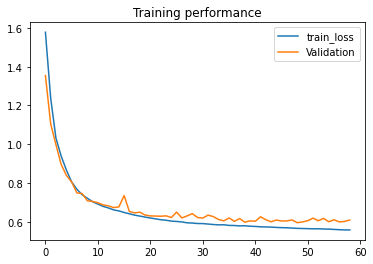

In [58]:
plt.figure()
plt.title('Training performance')
#plt.plot(history3.epoch, history3.history['loss'], label='train loss+error')
#plt.plot(history3.epoch, history3.history['val_loss'], label= 'val_loss')
plt.plot(history3.history['loss'], label='train_loss')
plt.plot(history3.history['val_loss'], label='Validation')
plt.legend()
plt.show()
